In [2]:
# import a few packages for the project
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, date, time

#packages for selection model features 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#packages for model training
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

#additional/service packages for model training
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

#packages for deep learning models
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [3]:
# path
path =  'https://raw.githubusercontent.com/user121989/Titanic_Kaggle-project/master/train.csv'
path_test = 'https://raw.githubusercontent.com/user121989/Titanic_Kaggle-project/master/test.csv'

In [4]:
# loading data
train = pd.read_csv(path, index_col='PassengerId')
test = pd.read_csv(path_test, index_col='PassengerId')

### Step 1. Explaratory Data Analysis
Let's reveal what the data set we have

In [5]:
display(train.head())
display(train.tail())

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


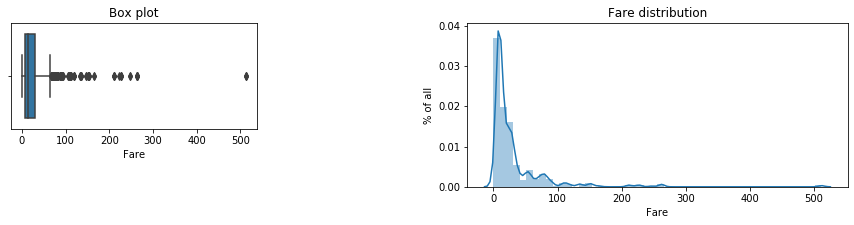

mean fare is:  32.2042079685746
median fare is:  14.4542


In [7]:
# checking outliers in 'Fare' column
plt.figure(figsize=(15, 10))
plt.subplot(3,3,1)
sns.boxplot(train.Fare)
plt.title('Box plot')
plt.xlabel("Fare")
plt.subplot(2,2,2)
sns.distplot(train.Fare)
plt.title('Fare distribution')
plt.xlabel('Fare')
plt.ylabel('% of all')
plt.subplots_adjust(bottom=0.25, top=0.75)
plt.show()
print('mean fare is: ',train.Fare.mean())
print('median fare is: ',train.Fare.median())

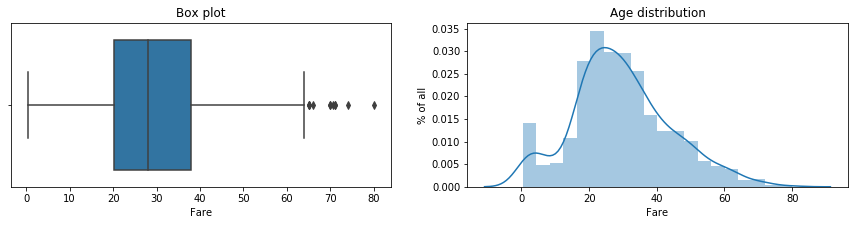

29.69911764705882
28.0


In [8]:
# checking outliers in 'Fare' column
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
sns.boxplot(train.Age)
plt.title('Box plot')
plt.xlabel("Fare")
plt.subplot(2,2,2)
sns.distplot(train.Age)
plt.title('Age distribution')
plt.xlabel('Fare')
plt.ylabel('% of all')
plt.subplots_adjust(bottom=0.25, top=0.75)
plt.show()
print(train.Age.mean())
print(train.Age.median())

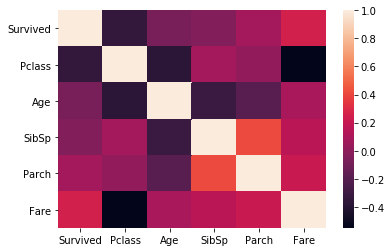

In [9]:
sns.heatmap(train.corr())

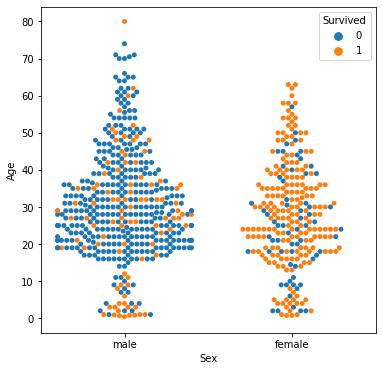

In [23]:
plt.figure(figsize=(6, 6))
sns.swarmplot(data = train, x = 'Sex', y='Age', hue='Survived')
plt.show()

###### EDA showed that the data set has a lot of missing data and existence of outliers. We will skip outliers now, but of course will handle the missing data problem.

### Step 2. Data clearning

Features engineering ideas and code was taken from this article https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/

In [9]:
# Creating label for social status

import string
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if str.find(big_string, substring) != -1:
            return substring
    print (big_string)
    return np.nan

title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']

train['Title'] = train['Name'].map(lambda x: substrings_in_string(x, title_list))
test['Title'] = test['Name'].map(lambda x: substrings_in_string(x, title_list))
 
#replacing all titles with mr, mrs, miss, master
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
    
train['Title']=train.apply(replace_titles, axis=1)
test['Title']=test.apply(replace_titles, axis=1)

In [10]:
# Creating additional feature family size
train['Family_size']=train.SibSp+train.Parch
test['Family_size']=test.SibSp+test.Parch

In [11]:
# category decoder
train.Sex.replace({'male':0, 'female':1}, inplace=True)
test.Sex.replace({'male':0, 'female':1}, inplace=True)

In [12]:
category_list=['Survived', 'Pclass', 'Sex']

train[category_list] = train[category_list].astype('category')

category_list_test=['Pclass', 'Sex']

test[category_list_test] = test[category_list_test].astype('category')

In [13]:
#Solving problems with  columns that include missing data and not suitable information
train.Age.fillna(value=test.Age.mean(), inplace=True)
test.Age.fillna(value=test.Age.mean(), inplace=True)

#Drop unsuitable for the further work features
list_todrop=['Cabin','Embarked', 'Ticket', 'Name']
train.drop(list_todrop, axis=1, inplace=True)
test.drop(list_todrop, axis=1, inplace=True)

In [14]:
# Get dummies variables
train = pd.get_dummies(train, columns=['Pclass', 'Title'])
test = pd.get_dummies(test, columns=['Pclass', 'Title'])

In [15]:
# Additional to the fare column in the test set, compute average in the Pclass_3 and replace with it nan values
PC_3_Mean = test[test['Pclass_3']==1].Fare.mean()
test.Fare.fillna(value=PC_3_Mean, inplace=True)

### Step 3. Building a  model

In [16]:
#Setup parametrs
X_train = train.loc[1:].drop('Survived', axis=1)
y_train = train.loc[1:].Survived = train.Survived



In [17]:
### Logistic regression with c-parametr tuning ###

steps_logreg = [('scaler', StandardScaler()),
         ('logreg', LogisticRegression())]


# Setup the hyperparameter grid
c_space = np.logspace(-5, 10, 20)
param_grid = {'logreg__C': c_space}

pipline_logreg = Pipeline(steps_logreg)


# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(pipline_logreg, param_grid, cv=5)


# Fit it to the data
logreg_cv.fit(X_train, y_train)  ######Better  use training data, not whole data


# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'logreg__C': 0.08858667904100832}
Best score is 0.8237775406440274


In [18]:
### KNN with a number of neighbors tuning ###


# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier


# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('knn', KNeighborsClassifier())]

pipeline_knn = Pipeline(steps)



# Setup the hyperparameter grid
param_grid = {'knn__n_neighbors': np.array(range(1,9))}

# Instantiate a KNN classifier: knn

# Instantiate the GridSearchCV object: knn_cv
knn_cv = GridSearchCV(pipeline_knn, param_grid, cv=5)

# Fit it to the data
knn_cv.fit(X_train, y_train)  ######Better  use training data, not whole data

# Print the tuned parameters and score
print("Tuned KNN Parameters: {}".format(knn_cv.best_params_)) 
print("Best score is {}".format(knn_cv.best_score_))

Tuned KNN Parameters: {'knn__n_neighbors': 5}
Best score is 0.8193333751804659


In [19]:
### Decision tree model with hyper parametrs tuning ###

# Setup the parameters and distributions to sample from: param_dist - _just a list of parametrs to check_
param_dist = {"max_depth": [3, None],
              "max_features": np.array(range(1,7)),
              "min_samples_leaf": np.array(range(1,7)),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = GridSearchCV(tree, param_dist, cv=5)

# Fit it to the data

tree_cv.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 4, 'min_samples_leaf': 4}
Best score is 0.827154604230745


In [20]:

### Define the dictionary 'params_rf'
params_rf = {
    'n_estimators':[int(x) for x in np.linspace(start = 100, stop = 500, num = 4)],
    'max_features':['log2','auto','sqrt'],
    'max_depth' : np.array(range(1,7)),
    'min_samples_leaf':[int(x) for x in np.linspace(start = 1, stop = 10, num = 4)],
    'criterion': ['gini', 'entropy']}



### Setup a model
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()

# Instantiate grid_rf
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       cv=3)

grid_rf.fit(X_train, y_train)


print("Tuned Random Forest Parameters: {}".format(grid_rf.best_params_))
print("Best score is {}".format(grid_rf.best_score_))


Tuned Random Forest Parameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100}
Best score is 0.8338945005611672


In [21]:
### GaussianNB model ###

G_NB = GaussianNB()

G_NB_scores = cross_val_score(
        G_NB, X_train, y_train,
        cv=5)

G_NB_scores.mean()

0.8148013307388112

In [22]:
### SVM model ###

# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('SVM', SVC())]

pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'SVM__C':[1, 10, 100],
              'SVM__gamma':[0.1, 0.01]}
#Specify the hyperparameter space for the C and gamma 
#the following notation:'step_name__parameter_name'. Here, the step_name is SVM, and the parameter_name is C/gamma.


# Instantiate the GridSearchCV object: cv
SVC = GridSearchCV(pipeline, parameters, cv=5)

# Fit to the training set
SVC.fit(X_train, y_train)

# Compute and print metrics
print("Tuned Model Parameters: {}".format(SVC.best_params_))
print("Best score is {}".format(SVC.best_score_))

Tuned Model Parameters: {'SVM__C': 10, 'SVM__gamma': 0.01}
Best score is 0.8327537505492437


In [23]:
### Set up AdaBoostClassifier

# Import AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

# Parametrs for griding
param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [1, 2]
             }


# Instantiate dt
dt = DecisionTreeClassifier(max_depth=2, random_state=1)

# Instantiate ada
ada = AdaBoostClassifier(base_estimator=dt)


grid_ada = GridSearchCV(estimator=ada,
                       param_grid=param_grid,
                       cv=3)

### Fitting the model and predicting probability of their decisions
# Fit ada to the training set
grid_ada.fit(X_train, y_train)



# Compute and print metrics
print("Tuned Model Parameters: {}".format(grid_ada.best_params_))
print("Best score is {}".format(grid_ada.best_score_))

Tuned Model Parameters: {'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'n_estimators': 2}
Best score is 0.8170594837261503


In [24]:
### Naive Bayes model

parameters_nb = [{'alpha':np.linspace(0.1,1,10)}]

BNB = BernoulliNB()
grid_BNB = GridSearchCV(estimator=BNB,
                       param_grid=parameters_nb,
                       cv=3)
grid_BNB.fit(X_train, y_train)

print("Tuned Model Parameters: {}".format(grid_BNB.best_params_))
print("Best score is {}".format(grid_BNB.best_score_))

Tuned Model Parameters: {'alpha': 0.1}
Best score is 0.7890011223344556


In [25]:
models_score = ({
    'AdaBoost' : grid_ada.best_score_,
'SVC' : SVC.best_score_,
'Random Forest' : grid_rf.best_score_,
'Desicion tree': tree_cv.best_score_,
'KNN': knn_cv.best_score_,
 'Logistic regression': logreg_cv.best_score_,
'Gaussin NB': G_NB_scores.mean(),
'Beroulli_NB': grid_BNB.best_score_})
models_score = pd.Series(models_score).to_frame('Model_score')
models_score = pd.DataFrame(models_score).reset_index()
models_score.rename(columns={'index':'Model_name'}, inplace=True)
models_score.sort_values(by='Model_score', inplace=True, ascending=False)

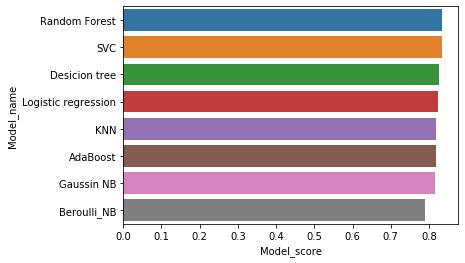

In [26]:
sns.barplot(x='Model_score',y='Model_name', data=models_score)
plt.show()

### Step 4. DEEP LEARNING MODELS

### Basic Keras Model - with one layer 

We initialize our model, add a layer that inputs vectors of length 13 and outputs vectors of length 2, and finally add a softmax layer. We configure the learning process in the compilation step by specifying the optimizer, loss function and performance metric.

Stochastic gradient descent acts by changing the weights gradually in the 'direction' that decreases the average loss. In other words, a particular weight would be increased if acts to decrease loss, or the weight decreased if it acts to increase loss.

=====================================================================================================================
_ADDITIONAL: If you have problems with kernel - next steps to fix it_

_1) pip uninstall PyQt5_

_2) conda update conda_

_3) conda update anaconda-navigator_

_4) conda install --force-reinstall pyqt qt_

_5) pip install --force-reinstall tensorflow_

=====================================================================================================================

In [30]:
from sklearn.model_selection import train_test_split
scaler = StandardScaler()

X_norm = scaler.fit_transform(X_train.values)
y_norm = y_train.values

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_norm, y_norm, test_size=0.20, random_state=42)
y_train_onehot = pd.get_dummies(y_train_dl).values
y_test_onehot = pd.get_dummies(y_test_dl).values

In [31]:
# pip install tensorflow keras - if necessary to install keras model

model = Sequential()
model.add(Dense(input_dim=13, units=2))
model.add(Activation("softmax"))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# early_stopping_monitor = EarlyStopping(patience=2)
model.fit(X_train_dl, y_train_onehot, epochs=10)


Epoch 1/10
712/712 [==============================] - 0s 433us/step - loss: 0.6957 - accuracy: 0.6264
Epoch 2/10
712/712 [==============================] - 0s 76us/step - loss: 0.6005 - accuracy: 0.7556
Epoch 3/10
712/712 [==============================] - 0s 71us/step - loss: 0.5436 - accuracy: 0.7865
Epoch 4/10
712/712 [==============================] - 0s 64us/step - loss: 0.5101 - accuracy: 0.7963
Epoch 5/10
712/712 [==============================] - 0s 68us/step - loss: 0.4871 - accuracy: 0.8020
Epoch 6/10
712/712 [==============================] - 0s 99us/step - loss: 0.4708 - accuracy: 0.8048
Epoch 7/10
712/712 [==============================] - 0s 71us/step - loss: 0.4601 - accuracy: 0.8062
Epoch 8/10
712/712 [==============================] - 0s 63us/step - loss: 0.4515 - accuracy: 0.8104
Epoch 9/10
712/712 [==============================] - 0s 88us/step - loss: 0.4452 - accuracy: 0.8132
Epoch 10/10
712/712 [==============================] - 0s 57us/step - loss: 0.4408 - accur

In [32]:
y_prediction = model.predict_classes(X_test_dl)
print ("\n\naccuracy", np.sum(y_prediction == y_test_dl) / float(len(y_test_dl)))



accuracy 0.7988826815642458


Let's add one more layer.

In [33]:
model = Sequential()
model.add(Dense(input_dim=13, units=100))
model.add(Dense(units=100))
model.add(Dense(units=2))
model.add(Activation("softmax"))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model.fit(X_train_dl, y_train_onehot, epochs=10)

Epoch 1/10
712/712 [==============================] - 0s 171us/step - loss: 0.5432 - accuracy: 0.7388
Epoch 2/10
712/712 [==============================] - 0s 108us/step - loss: 0.4604 - accuracy: 0.8048
Epoch 3/10
712/712 [==============================] - 0s 89us/step - loss: 0.4385 - accuracy: 0.8174
Epoch 4/10
712/712 [==============================] - 0s 71us/step - loss: 0.4299 - accuracy: 0.8287
Epoch 5/10
712/712 [==============================] - 0s 90us/step - loss: 0.4252 - accuracy: 0.8315
Epoch 6/10
712/712 [==============================] - 0s 77us/step - loss: 0.4232 - accuracy: 0.8315
Epoch 7/10
712/712 [==============================] - 0s 120us/step - loss: 0.4222 - accuracy: 0.8301
Epoch 8/10
712/712 [==============================] - 0s 64us/step - loss: 0.4218 - accuracy: 0.8315
Epoch 9/10
712/712 [==============================] - 0s 100us/step - loss: 0.4218 - accuracy: 0.8315
Epoch 10/10
712/712 [==============================] - 0s 161us/step - loss: 0.4204 - a

In [34]:
y_prediction = model.predict_classes(X_test_dl)
print ("\n\naccuracy", np.sum(y_prediction == y_test_dl) / float(len(y_test_dl)))



accuracy 0.8100558659217877


### 5. Computing The Final Result

### DL_prediction

In [35]:
X_test_norm = scaler.fit_transform(test.values)
y_test_prediction_dl = model.predict_classes(X_test_norm)
dl_prediction = pd.Series(y_test_prediction_dl, index= list(range(892,1310))).to_frame('Survived')
dl_prediction.index.name= 'PassengerId'
dl_prediction.to_csv('/Users/anatolyabramovich/Desktop/Documents/Study/Kaggle/Titanic/DL_prediction.csv')
# kaggle score 0.77990

### RF_prediction

In [37]:
prediction_rf = grid_rf.predict(test)
rf_prediction = pd.Series(prediction_rf, index= list(range(892,1310))).to_frame('Survived')
rf_prediction.index.name= 'PassengerId'
# kaggle score 0.78468